In [1]:
!wget -q --show-progress https://github.com/sparsh-ai/ieee21cup-recsys/raw/main/data/bronze/train.parquet.snappy

train.parquet.snapp 100%[===================>]  65.26M  96.2MB/s    in 0.7s    


In [18]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
trainset = pd.read_parquet('train.parquet.snappy')
trainset

,user_id,user_click_history,user_protrait,exposed_items,labels,time
0,1,"30:1580603130,34:1581178937,15:1581178939,28:1...","64054,21804,80911,36504,8867,7615,54240,37294,...","1,20,28,99,86,119,213,237,164","1,1,1,1,1,1,1,1,1",1582992009
1,2,"20:1580644762,13:1580644765,1:1580644770,127:1...","64054,26565,93755,88510,6344,7615,54240,21927,...","1,4,26,112,86,117,191,234,172","1,1,1,1,1,1,1,1,0",1582992010
2,3,"39:1580772975,6:1580772981,1:1581178309,2:1581...","64054,64086,63021,88510,93500,7615,54240,21927...","22,4,28,48,105,42,193,236,159","1,1,1,0,1,0,0,0,0",1582992014
3,4,"6:1580657608,9:1580657612,15:1580657615,127:15...","64054,21531,6599,16721,37078,7615,54240,65505,...","5,16,1,74,133,122,235,218,172","1,1,1,1,1,1,1,1,0",1582992014
4,5,"37:1580743545,36:1580743554,25:1580743556,37:1...","64054,66036,6599,88510,76066,20543,83978,37294...","6,1,16,85,73,112,239,172,205","1,1,1,1,1,1,1,1,1",1582992017
...,...,...,...,...,...,...
260082,260083,"18:1590866211,29:1590866361,7:1590866364,7:159...","64054,7723,93755,16721,35011,93364,83978,37294...","29,31,25,127,111,93,171,150,196","0,0,0,0,0,0,0,0,0",1593014108
260083,260084,"34:1590594937,15:1590594939,30:1590594941,133:...","64054,46479,34810,36504,7411,11973,83978,93716...","34,14,9,106,114,86,214,154,172","1,1,1,1,1,1,0,0,1",1593014287
260084,260085,"34:1590594937,15:1590594939,30:1590594941,133:...","64054,46479,34810,36504,7411,11973,83978,93716...","28,35,5,110,125,78,218,200,164","1,1,1,1,1,1,0,1,1",1593014307
260085,260086,"28:1591026017,10:1591026019,25:1591026021,132:...","64054,46485,93755,16721,98428,11973,83978,2192...","30,4,22,105,43,129,172,217,238","1,1,1,1,1,1,1,1,0",1593014325


In [5]:
# There are a total of 260087 rows, we randomly choose 10k data for EDA purpose
trainset_10k = trainset.sample(n=10000, random_state=42)
trainset_10k

,user_id,user_click_history,user_protrait,exposed_items,labels,time
82869,82870,"10:1583684355,38:1583684361,21:1583684364,21:1...","92265,47090,6599,88510,3038,63681,83978,21927,...","33,29,7,80,136,101,222,191,181","1,1,1,1,1,1,0,1,0",1586017239
71700,71701,"16:1583032568,26:1583032570,29:1583032573,86:1...","64054,989,6599,88510,44093,20543,83978,50138,7...","10,1,14,81,84,125,237,184,172","0,1,0,0,0,0,0,0,0",1585447817
66738,66739,"28:1582993882,34:1582993884,15:1582993893,41:1...","64054,16770,52700,88510,44093,20543,83978,5013...","22,14,1,127,77,72,233,235,164","1,1,1,1,1,1,1,1,1",1585413028
180550,180551,0:0,"64054,66662,6599,88510,87671,39206,83978,65505...","36,34,18,59,42,130,165,168,234","0,0,0,0,0,0,0,0,0",1589705842
40943,40944,"21:1582462284,27:1582462286,5:1582462288,21:15...","64054,5205,6599,16721,38416,7615,54240,50138,7...","1,14,23,135,107,86,211,164,184","1,1,1,1,1,1,1,1,1",1584259673
...,...,...,...,...,...,...
189876,189877,"1:1587831190,12:1587831192,14:1587831194,77:15...","64054,38519,22789,88510,65289,7615,54240,21927...","34,15,28,137,126,89,192,164,212","1,1,1,1,1,1,1,1,1",1590274240
213250,213251,"29:1589299269,20:1589299275,14:1589299278,80:1...","92265,51976,34810,36504,75610,7615,54240,6560,...","29,14,35,51,112,131,200,233,164","1,1,1,1,1,1,1,1,1",1591027319
150850,150851,"14:1586049739,11:1586049742,12:1586049744,132:...","64054,43415,78388,36504,37014,7615,54240,37294...","1,5,18,107,81,61,239,200,170","1,1,1,1,1,1,1,1,0",1588521052
84043,84044,"1:1583597420,35:1583597598,39:1583597601,79:15...","64054,63411,34810,16721,59460,20543,83978,3729...","1,11,21,54,110,115,192,235,163","1,1,1,1,1,1,1,1,0",1586018452


### Distribution of items bought

We first try the easiest: we want to see the distribution of ppl who bought 0, 1, 2, ... 9 items

In [8]:
cnt_dict = {}  # how many ppl bought 0, 1, 2, ... 9 items
for index, row in trainset_10k.iterrows():
    item_ids = row['exposed_items'].split(',')
    is_bought = row['labels'].split(',')
    bought_amount = 0
    for i in range(0, len(is_bought)):
        if is_bought[i] == '1':
            bought_amount += 1
    if bought_amount not in cnt_dict:
        cnt_dict[bought_amount] = 1
    else:
        cnt_dict[bought_amount] += 1

cnt_dict

{0: 1209,
 1: 1066,
 2: 588,
 3: 260,
 4: 607,
 5: 602,
 6: 198,
 7: 1319,
 8: 2678,
 9: 1473}

In [13]:
data_display = []
for i in range(0, 10):
    data_display.append(cnt_dict[i])

data_display

[1209, 1066, 588, 260, 607, 602, 198, 1319, 2678, 1473]

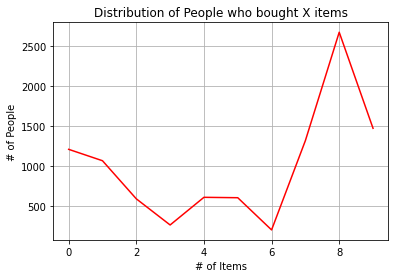

In [14]:
plt.plot(data_display, color = 'r')
plt.title('Distribution of People who bought X items')
plt.xlabel('# of Items')
plt.ylabel('# of People')
plt.grid(True)
plt.show()

So most people tend to buy 8 items, 2671 ppl out of 10k.

### Distribution of user protrait

choose the top 10 user protraits as classifying features

In [19]:
cnt_dict = {}  
for index, row in tqdm(trainset_10k.iterrows(), total=len(trainset_10k)):
    user_protraits = row['user_protrait'].split(',')
    for user_protrait in user_protraits:
        if user_protrait not in cnt_dict:
            cnt_dict[user_protrait] = 1
        else:
            cnt_dict[user_protrait] += 1

user_protrait_cnt_dict = cnt_dict
user_protrait_cnt_list = [(k,v) for k, v in sorted(user_protrait_cnt_dict.items(), key=lambda item: item[1], reverse=True)]

top_10_features = user_protrait_cnt_list[:10]
top_10_features

  0%|          | 0/10000 [00:00<?, ?it/s]

[('74820', 9775),
 ('64054', 8829),
 ('83978', 6482),
 ('6599', 5432),
 ('36504', 4439),
 ('7615', 3526),
 ('54240', 3526),
 ('37294', 3163),
 ('21927', 2887),
 ('11973', 1452)]

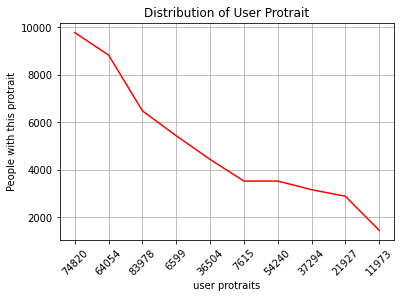

In [16]:
fig,ax = plt.subplots()
ax.set_xticks([i for i in range(0, 10)])
ax.set_xticklabels([x[0] for x in top_10_features])

plt.plot([x[1] for x in top_10_features], color = 'r')
plt.xticks(rotation=45)
plt.grid(True)
plt.title('Distribution of User Protrait')
plt.xlabel('user protraits')
plt.ylabel('People with this protrait')
plt.show()

In [20]:
columns = ['user_id'] + [x[0] for x in top_10_features] + ['item_' + str(i) for i in range(1, 382)]
processed_trainset = pd.DataFrame([], columns = columns)
cnt = 3

for index, row in tqdm(trainset_10k.iterrows(), total=len(trainset_10k)):
    user_protraits = row['user_protrait'].split(',')
    user_id = str(row['user_id'])
    to_insert = {}

    # mark features
    for column in processed_trainset:
        if column == 'user_id':
            to_insert['user_id']=user_id
        elif not column.startswith('item_'):
            if column in user_protraits:
                to_insert[column]=1
            else:
                to_insert[column]=0
                
    # mark items
    exposed_items = row['exposed_items'].split(',')
    labels = row['labels'].split(',')

    for i in range(0, len(exposed_items)):
        cur_item = 'item_' + exposed_items[i]
#         print(cur_item)
#         print(labels[i])
        to_insert[cur_item] = labels[i]  
    
#     for i in range(1, 382):
#         cur_item_id = 'item_' + str(i)
#         if cur_item_id not in to_insert:
#             to_insert[cur_item_id] = np.nan
    # print(to_insert)
    processed_trainset = processed_trainset.append(to_insert, ignore_index=True)
#     cnt -= 1
    if cnt <= 0:
        break

  0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
processed_trainset

,user_id,74820,64054,83978,6599,36504,7615,54240,37294,21927,11973,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,...,item_342,item_343,item_344,item_345,item_346,item_347,item_348,item_349,item_350,item_351,item_352,item_353,item_354,item_355,item_356,item_357,item_358,item_359,item_360,item_361,item_362,item_363,item_364,item_365,item_366,item_367,item_368,item_369,item_370,item_371,item_372,item_373,item_374,item_375,item_376,item_377,item_378,item_379,item_380,item_381
0,82870,1,0,1,1,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71701,1,1,1,1,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,66739,1,1,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,180551,1,1,1,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40944,1,1,0,1,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,189877,1,1,0,0,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,213251,1,0,0,0,1,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,150851,1,1,0,0,1,1,1,1,0,0,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,84044,1,1,1,0,0,0,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
processed_trainset.to_parquet('processed_trainset.parquet.snappy', compression='snappy')

In [22]:
from sklearn.ensemble import RandomForestClassifier

cur_item = 'item_1'

cur_Xy = processed_trainset[~processed_trainset[cur_item].isnull()]
train_test_perc = 0.8
cur_len = len(cur_Xy)

cur_Xy_train = cur_Xy.head(int(cur_len * train_test_perc))
cur_Xy_test = cur_Xy.tail(cur_len - int(cur_len * train_test_perc))

In [23]:
print(cur_len)
print(len(cur_Xy_train))
print(len(cur_Xy_test))

1812
1449
363


In [24]:
cur_Xy_train

,user_id,74820,64054,83978,6599,36504,7615,54240,37294,21927,11973,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,...,item_342,item_343,item_344,item_345,item_346,item_347,item_348,item_349,item_350,item_351,item_352,item_353,item_354,item_355,item_356,item_357,item_358,item_359,item_360,item_361,item_362,item_363,item_364,item_365,item_366,item_367,item_368,item_369,item_370,item_371,item_372,item_373,item_374,item_375,item_376,item_377,item_378,item_379,item_380,item_381
1,71701,1,1,1,1,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,66739,1,1,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40944,1,1,0,1,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,77793,1,1,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,93979,1,1,0,0,0,1,1,1,0,0,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7942,25086,1,1,1,0,0,0,0,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7943,217883,1,1,0,0,0,1,1,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7961,48584,1,1,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7971,52655,1,1,0,0,0,1,1,0,1,0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
top_10_feature_ids = [x[0] for x in top_10_features]
X_train = cur_Xy_train[[x[0] for x in top_10_features]]
y_train = cur_Xy_train[cur_item]

X_test = cur_Xy_test[[x[0] for x in top_10_features]]
y_test = cur_Xy_test[cur_item]

In [26]:
X_train

,74820,64054,83978,6599,36504,7615,54240,37294,21927,11973
1,1,1,1,1,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0
4,1,1,0,1,0,1,1,0,0,0
11,1,1,1,0,0,0,0,0,0,0
29,1,1,0,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
7942,1,1,1,0,0,0,0,1,0,0
7943,1,1,0,0,0,1,1,0,1,0
7961,1,1,1,0,0,0,0,0,0,0
7971,1,1,0,0,0,1,1,0,1,0


In [27]:
y_train

1       1
2       1
4       1
11      1
29      1
       ..
7942    1
7943    1
7961    1
7971    1
7974    1
Name: item_1, Length: 1449, dtype: object

In [28]:
model = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

prediction_accuracy = (predictions==y_test).sum() / len(y_test)
prediction_accuracy

0.8732782369146006

In [29]:
from sklearn.ensemble import RandomForestClassifier

print_list = []

all_rf = {}
accuracy_dict = {}
cnt = 10
for i in range(1, 382):
    cur_item = 'item_' + str(i)
    cur_Xy = processed_trainset[~processed_trainset[cur_item].isnull()]
    if len(cur_Xy) == 0:
        print_list.append('Item {} never showed up.'.format(i))
        continue
    if len(cur_Xy) < 10:
        print_list.append('Item {} showed up less than 10 times.'.format(i))
        continue    
    train_test_perc = 0.8
    cur_len = len(cur_Xy)

    cur_Xy_train = cur_Xy.head(int(cur_len * train_test_perc))
    cur_Xy_test = cur_Xy.tail(cur_len - int(cur_len * train_test_perc))    
    X_train = cur_Xy_train[[x[0] for x in top_10_features]]
    y_train = cur_Xy_train[cur_item]

    X_test = cur_Xy_test[[x[0] for x in top_10_features]]
    y_test = cur_Xy_test[cur_item]
    
    model = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)    
    
    accuracy = (predictions==y_test).sum() / len(y_test)
    accuracy_dict[i] = accuracy
    print_list.append('Item {} has accuracy {}'.format(i, accuracy))
    
    X = cur_Xy[[x[0] for x in top_10_features]]
    y = cur_Xy[cur_item]
    model = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)
    model.fit(X, y)
    
    all_rf[i] = model
        
#     cnt -= 1
    if cnt <=0:
        break

In [30]:
print(', '.join(print_list))

Item 1 has accuracy 0.8732782369146006, Item 2 has accuracy 0.8018018018018018, Item 3 has accuracy 0.7701863354037267, Item 4 has accuracy 0.7207792207792207, Item 5 has accuracy 0.8299595141700404, Item 6 has accuracy 0.7744360902255639, Item 7 has accuracy 0.7272727272727273, Item 8 has accuracy 0.6237623762376238, Item 9 has accuracy 0.6666666666666666, Item 10 has accuracy 0.6827586206896552, Item 11 has accuracy 0.8255813953488372, Item 12 has accuracy 0.7808219178082192, Item 13 has accuracy 0.7831325301204819, Item 14 has accuracy 0.8789625360230547, Item 15 has accuracy 0.8516483516483516, Item 16 has accuracy 0.8035714285714286, Item 17 has accuracy 0.7614678899082569, Item 18 has accuracy 0.762589928057554, Item 19 has accuracy 0.7833333333333333, Item 20 has accuracy 0.808695652173913, Item 21 has accuracy 0.6948051948051948, Item 22 has accuracy 0.5925925925925926, Item 23 has accuracy 0.7878787878787878, Item 24 has accuracy 0.7326732673267327, Item 25 has accuracy 0.7094

In [31]:
len(accuracy_dict.keys())

246

In [37]:
print(', '.join([str(k)+':'+str(v.round(2)) for k,v in accuracy_dict.items()]))

1:0.87, 2:0.8, 3:0.77, 4:0.72, 5:0.83, 6:0.77, 7:0.73, 8:0.62, 9:0.67, 10:0.68, 11:0.83, 12:0.78, 13:0.78, 14:0.88, 15:0.85, 16:0.8, 17:0.76, 18:0.76, 19:0.78, 20:0.81, 21:0.69, 22:0.59, 23:0.79, 24:0.73, 25:0.71, 26:0.79, 27:0.82, 28:0.88, 29:0.85, 30:0.76, 31:0.86, 32:0.8, 33:0.77, 34:0.78, 35:0.73, 36:0.66, 37:0.72, 38:0.71, 39:0.73, 40:0.45, 41:0.65, 42:0.79, 43:0.65, 44:0.73, 45:0.72, 46:0.65, 47:0.73, 48:0.75, 49:0.81, 50:0.72, 51:0.64, 52:0.58, 53:0.5, 54:0.61, 55:0.59, 56:0.58, 57:0.77, 58:0.6, 59:0.61, 60:0.9, 61:0.6, 62:0.2, 63:0.5, 64:0.5, 65:0.67, 66:0.67, 67:0.67, 68:0.67, 69:0.67, 70:0.5, 71:0.75, 72:0.7, 73:0.78, 74:0.72, 75:0.68, 76:0.68, 77:0.68, 78:0.69, 79:0.76, 80:0.64, 81:0.75, 82:0.6, 83:0.61, 84:0.66, 85:0.57, 86:0.82, 87:0.49, 88:0.64, 89:0.56, 90:1.0, 91:0.5, 92:0.6, 93:0.62, 94:0.5, 95:0.6, 96:0.67, 97:1.0, 98:0.5, 99:0.71, 100:0.74, 101:0.74, 102:0.52, 103:0.66, 104:0.64, 105:0.63, 106:0.56, 107:0.7, 108:0.55, 109:0.61, 110:0.5, 111:0.53, 112:0.48, 113:0.67, 

In [39]:
!wget -q --show-progress https://github.com/sparsh-ai/ieee21cup-recsys/raw/main/data/bronze/track1_testset.parquet.snappy
testset = pd.read_parquet('track1_testset.parquet.snappy')
testset

track1_testset.parq 100%[===================>]  48.66M   102MB/s    in 0.5s    


,user_id,user_click_history,user_protrait,exposed_items,labels,time
0,1,"24:1580573710,7:1580573724,1:1580573730,127:15...","64054,50887,66367,44932,59460,20543,83978,5013...","3,5,29,72,53,52,164,211,172","0,0,0,0,0,0,0,0,0",1582992008
1,2,"35:1580629376,9:1580629379,2:1580629381,73:158...","64054,35323,6599,36504,24180,37350,83978,21927...","22,29,25,132,73,108,188,213,164","0,0,0,0,0,0,0,0,0",1582992009
2,3,"35:1580804903,32:1580804915,39:1581268224,33:1...","64054,67884,6599,16721,17121,38762,83978,37294...","29,35,14,61,51,106,150,148,234","0,0,0,0,0,0,0,0,0",1582992019
3,4,"15:1580688381,5:1580688385,39:1580688388,39:15...","64054,23083,93755,36504,35011,37350,83978,3729...","29,27,35,99,79,107,213,200,152","0,0,0,0,0,0,0,0,0",1582992024
4,5,"29:1580906648,18:1580906650,10:1580906652,139:...","64054,32125,93755,36504,37741,7615,54240,21927...","4,8,28,102,61,86,151,235,199","0,0,0,0,0,0,0,0,0",1582992027
...,...,...,...,...,...,...
206249,206250,0:0,"92265,96861,6599,36504,76066,11973,83978,16279...","28,32,25,77,126,127,164,233,200","0,0,0,0,0,0,0,0,0",1593014193
206250,206251,"8:1590906369,24:1590906371,37:1590906373,82:15...","64054,87540,6599,73143,24180,11973,83978,37294...","39,10,32,130,113,48,158,168,153","0,0,0,0,0,0,0,0,0",1593014200
206251,206252,0:0,"64054,5205,6599,36504,65289,7615,54240,37294,7...","6,16,4,80,99,51,200,150,234","0,0,0,0,0,0,0,0,0",1593014247
206252,206253,"28:1590480010,31:1590480012,10:1590480014,80:1...","64054,33685,6599,36504,56754,7615,54240,37294,...","15,24,7,58,139,53,190,164,220","0,0,0,0,0,0,0,0,0",1593014372


In [43]:
import time

test_result = pd.DataFrame([], columns = ['id', 'category'])

start_time = int(time.time())
cnt = 1

for index, row in tqdm(testset.iterrows(), total=len(testset)):
#     print(row)
    item_ids = row['exposed_items'].split(',')
    user_protraits = row['user_protrait'].split(',')
#     user_protraits = row['user_protrait'].split(',')    
    cur_X = pd.DataFrame([], columns = top_10_feature_ids)

    to_insert = {}
    for column in cur_X:
        if column in user_protraits:
            to_insert[column]=1
        else:
            to_insert[column]=0
#     print('to_insert')
#     print(to_insert)
    cur_X = cur_X.append(to_insert, ignore_index=True)
#     print('cur_X')        
#     print(cur_X)
    predictions = []
    for item_id in item_ids:
        item_id = int(item_id)
        if item_id in all_rf:
            cur_pred = all_rf[item_id].predict(cur_X)
#             print('Pred item {} is {}'.format(item_id, cur_pred))
            if int(cur_pred) > 0.5:
                cur_pred = 1
            else:
                cur_pred = 0
        else:
            # buy is more than not-buy
            cur_pred = 1
        predictions.append(cur_pred)
#     print('predictions')
#     print(predictions)

#     test_result_to_insert['id'] = row['user_id']
    predictions = [str(p) for p in predictions]
#     test_result_to_insert['category'] = ' '.join(predictions)   
    
    test_result_to_insert = {'id': row['user_id'], 'category': ' '.join(predictions)}   
    test_result = test_result.append(test_result_to_insert, ignore_index=True)
    cnt += 1

print('finally all done')

  0%|          | 0/206254 [00:00<?, ?it/s]

finally all done


In [44]:
test_result

,id,category
0,1,1 1 1 1 1 1 1 1 0
1,2,1 1 0 0 0 0 0 0 0
2,3,1 1 1 1 1 1 0 0 1
3,4,1 1 1 1 1 1 0 1 0
4,5,1 0 1 1 1 1 0 1 0
...,...,...
206249,206250,1 1 1 1 1 1 0 0 1
206250,206251,1 1 1 1 0 0 0 0 0
206251,206252,1 1 1 1 0 1 1 0 1
206252,206253,1 1 1 0 1 0 0 0 0


In [45]:
test_result.to_parquet('test_result.parquet.snappy', compression='snappy')

In [47]:
import os
project_name = "ieee21cup-recsys"; branch = "main"; account = "sparsh-ai"
project_path = os.path.join('/content', branch)

!cp -r /content/drive/MyDrive/git_credentials/. ~
!mkdir "{project_path}"
%cd "{project_path}"
!git init
!git remote add origin https://github.com/"{account}"/"{project_name}".git
!git pull origin "{branch}"
!git checkout -b "{branch}"

!mkdir -p data/silver/T604426
!mv /content/test_result.parquet.snappy data/silver/T604426
!mv /content/processed_trainset.parquet.snappy data/silver/T604426

!git add .
!git commit -m 'commit'
!git push origin main

/content/main
Initialized empty Git repository in /content/main/.git/
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 1), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.
From https://github.com/sparsh-ai/ieee21cup-recsys
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main
Switched to a new branch 'main'
